In [29]:
#seu código vai aqui
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
from shutil import rmtree

def getNSamples(N: int, return_labels=False):
    samples = []
    labels = []
    for _ in range(N):
        person = np.random.choice(os.listdir("train"))
        image = np.random.choice(os.listdir(f"train/{person}"))
        samples.append(cv.imread(f"train/{person}/{image}", cv.IMREAD_GRAYSCALE))
        labels.append(person)
    if(return_labels):
        return samples, labels
    return samples

def plotN(samples):
    N = len(samples)
    if not int(np.sqrt(N) + 0.5) ** 2 == N:
        print("Number of samples must be a perfect square!")
        return None
    l = int(np.sqrt(N) + 0.5)
    size = min(l*3, 24)
    fig = plt.figure(figsize=(size, size))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(l, l),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, samples):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, cmap="gray")

    plt.show()

def getAllSamplesFromFolder(FolderName, return_labels=False):
    samples = []
    labels = [FolderName]*len(os.listdir(f"train/{FolderName}"))
    for file in os.listdir(f"train/{FolderName}"):
        samples.append(cv.imread(f"train/{FolderName}/{file}", cv.IMREAD_GRAYSCALE))
    if(return_labels):
        return samples, labels
    return samples

def extract_cornea(samples, debug=False):
    kernel = np.ones((9,9),np.uint8)
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        processed_img = cv.GaussianBlur(img,(3,3),cv.BORDER_DEFAULT)
        # processed_img = cv.medianBlur(img, 3)
        processed_img = cv.morphologyEx(processed_img, cv.MORPH_OPEN, kernel)
        # processed_img = cv.equalizeHist(img)
        ret = cv.HoughCircles(processed_img, method=cv.HOUGH_GRADIENT, dp=2, minDist=85, param1=65, param2=40, minRadius=30, maxRadius=100)
        iter = 0
        if(ret is not None):
            for circ in ret[0].astype(int):
                if(iter>2):
                    continue
                if debug:
                    if iter == 0:
                        cv.circle(processed_img,(circ[0],circ[1]),200,(255),4)
                    else:
                        cv.circle(processed_img,(circ[0],circ[1]),200,(0),4)
                else:
                    if iter == 0:
                        cv.circle(img,(circ[0],circ[1]),200,(255),4)
                    else:
                        cv.circle(img,(circ[0],circ[1]),200,(0),4)
                iter+=1
        if debug:
            samples_processed[i] = processed_img.copy()
        else:
            samples_processed[i] = img.copy()
    return samples_processed

def simpleCleanup(samples, cL = 30, tGS = (5,5)):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        processed_img = cv.medianBlur(img, 3)
        clahe = cv.createCLAHE(clipLimit = cL, tileGridSize= tGS)
        processed_img = clahe.apply(processed_img)
        samples_processed[i] = processed_img.copy()
    return samples_processed


def morphEx(samples):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        ## Code goes here
        processed_img = cv.morphologyEx(img, cv.MORPH_OPEN, np.ones((7,7),np.uint8))
        samples_processed[i] = processed_img.copy()
    return samples_processed


def meanPixelSample(samples):
    mean = 0
    for img in samples:
        flatten_img = img.flatten()
        mean_pxl = np.mean(flatten_img)
        mean += mean_pxl
    mean /=len(samples)
    return mean

def createClahe(samples):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        clahe = cv.createCLAHE(clipLimit = 30, tileGridSize= (5,5))
        processed_img = clahe.apply(img)
        samples_processed[i] = processed_img.copy()
    return samples_processed
    

def histEqualization(samples):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        processed_img = cv.equalizeHist(img)
        samples_processed[i] = processed_img.copy()
    return samples_processed

def gausBlur(samples):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        processed_img = cv.GaussianBlur(img,(3,3),cv.BORDER_DEFAULT)
        samples_processed[i] = processed_img.copy()
    return samples_processed


def applyFunctions(samples, functions):
    samples_processed = [0]*len(samples)
    firstFunc = True
    for f in functions:
        if firstFunc == True:
            samples_processed = f(samples)
            firstFunc = False
        else:
            samples_processed = f(samples_processed)
    return samples_processed

def centerHist(samples):
    samples_processed = [0]*len(samples)
    for i in range(len(samples)):
        img = samples[i]
        imgMedian = np.median(img.flatten())
        processed_img = cv.add(img, 127-imgMedian)
        samples_processed[i] = processed_img.copy()
    return samples_processed
    


In [15]:
# Number of samples
experiments = [{"cL":30+i, "tGS":(5,5)} for i in range(-15,16)]
N = 16
samples = getNSamples(N)
for exp in experiments:
    print(exp)
    samples_processed = comboCleanup(samples, exp)
    # samples_processed = extract_cornea(samples_processed, True)
    plotN(samples_processed)

{'cL': 15, 'tGS': (5, 5)}


NameError: name 'comboCleanup' is not defined

In [ ]:
# Number of samples
experiments = [{"cL":30, "tGS":(5,5)}]
N = 100
samples, labels = getNSamples(N, True)
for exp in experiments:
    print(exp)
    samples_processed = simpleCleanup(samples, exp["cL"], exp["tGS"])
    # samples_processed = extract_cornea(samples_processed, True)
    plotN(samples_processed)

In [ ]:
if "processedTraining" in os.listdir():
    rmtree("processedTraining")
os.mkdir("processedTraining")
for l in os.listdir("train"):
    try:
        os.mkdir(f"processedTraining/{l}")
    except WindowsError:
        continue


for folder_name in os.listdir("train"):
    for fn in os.listdir(f"train/{folder_name}"):
        img = cv.imread(f"train/{folder_name}/{fn}", cv.IMREAD_GRAYSCALE)
        processed_img = simpleCleanup([img], cL=15, tGS=(7,7))[0]
        cv.imwrite(f"processedTraining/{folder_name}/{fn}", processed_img)


In [ ]:
# Number of samples
experiments = [{"cL":15, "tGS":(7,7)}]
N = 36
samples, labels = getNSamples(N, True)
for exp in experiments:
    print(exp)
    samples_processed = simpleCleanup(samples, exp["cL"], exp["tGS"])
    # samples_processed = extract_cornea(samples_processed, True)
    plotN(samples_processed)

In [ ]:
if "processedTest" in os.listdir():
    rmtree("processedTest")
os.mkdir("processedTest")
for i in range(N):
    cv.imwrite(f"processedTest/{i}.bmp", samples_processed[i])

In [ ]:
ik = cv.imread(f"processedTest/0.bmp", cv.IMREAD_GRAYSCALE)
print(ik.shape)
plt.imshow(ik, cmap="gray")


In [ ]:
N = 25
samples, labels = getNSamples(N, True)

In [ ]:
plotN(samples)

In [ ]:
funcs1 = [centerHist]
funcs2 = [createClahe]

In [ ]:
transform1 = applyFunctions(samples, funcs1)
plotN(transform1)

In [ ]:
transform2 = applyFunctions(samples, funcs2)
plotN(transform2)

In [ ]:
transform3 = applyFunctions(transform1, funcs2)
plotN(transform3)

In [16]:
samples = getAllSamplesFromFolder("0001")
samples.append(samples[-1])

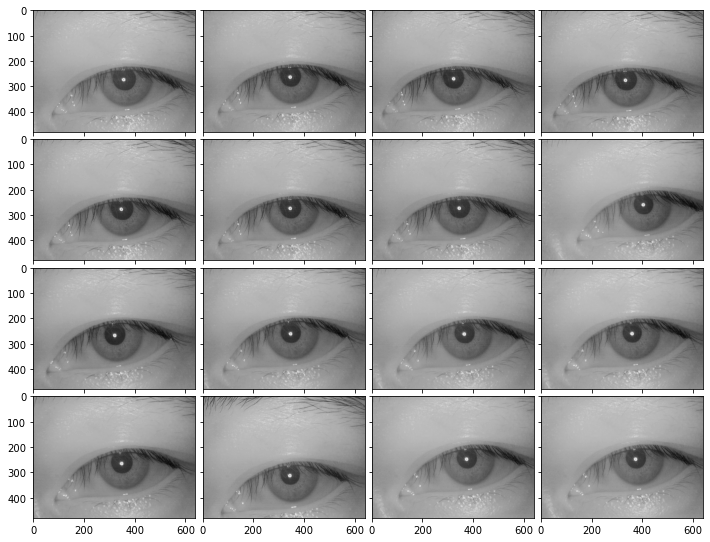

In [17]:
plotN(samples)

In [38]:
"""
morphEx(samples):

createClahe(samples):

histEqualization(samples):

gausBlur(samples):

def applyFunctions(samples, functions):

centerHist(samples):

morphExClose
"""

def morphExClose(samples):
    samples_processed = [0]*len(samples)
    kernel = np.ones((5,5),np.uint8)
    for i in range(len(samples)):
        img = samples[i]
        ## Code goes here
        processed_img = cv.morphologyEx(img,cv.MORPH_CLOSE,kernel, iterations = 1)
        samples_processed[i] = processed_img.copy()
    return samples_processed

samples_processed = applyFunctions(samples, [morphExClose])
plotN(samples_processed) 


**PROJETO IRIS - DATA DE ENTREGA: 07/10/2020**


*   Crie um modelo de treinamento usando a base de dados fornecida (60 pessoas com 20 íris cada ~ 1200 imagens). Durante o treinamento, você pode utilizar qualquer procedimento para melhorar a qualidade das imagens.
*   Obtenha a matriz de confusão do seu modelo e analise os resultados

**O que entregar:** notebook implementado em Python. 


